<a href="https://colab.research.google.com/github/JohnMommers/Calculate-All-RDKIT-Descriptors/blob/main/Mol_To_Spectrum_003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mol to Spectrum
John Mommers
20-01-2021


In [1]:
# install rdkit
!pip install rdkit-pypi

# install deepchem
!pip install deepchem

     |████████████████████████████████| 20.4 MB 57.0 MB/s 
     |████████████████████████████████| 552 kB 13.8 MB/s 


In [2]:
import deepchem as dc
import numpy as np
import pandas as pd
import rdkit as rk
from rdkit import Chem 
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
rk.__version__

'2021.09.2'

##LOAD DATA (MASS SPECTRA OF HYDROCARBONS ONLY)

In [3]:
# LOAD DATA X = SMILES and y = mass intensity of mass 1 to 1000
ms = pd.read_pickle('/content/drive/MyDrive/NIST/ms_only_CH')
ms = ms.sample(frac=1) # randomize dataframe 
ms.reset_index(inplace=True, drop=True) # reset and replace the index

In [5]:
ms.shape

(6481, 1007)

In [76]:
X = np.array(ms['smiles'][:])
y = np.array(ms.iloc[:, 4:1004])

# DiskDataset (for large datasets) 
dataset = dc.data.DiskDataset.from_numpy(X,y)

In [77]:
# featurizing
featurizer = dc.feat.ConvMolFeaturizer()
features = featurizer.featurize(dataset.X)
dataset = dc.data.NumpyDataset(X=features, y=np.array(dataset.y).astype('float32'))
dataset

RDKit WARNING: [18:49:11] Conflicting single bond directions around double bond at index 4.
RDKit WARNING: [18:49:11]   BondStereo set to STEREONONE and single bond directions set to NONE.


<NumpyDataset X.shape: (6481,), y.shape: (6481, 1000), w.shape: (6481, 1), task_names: [  0   1   2 ... 997 998 999]>

In [78]:
splitter = dc.splits.RandomStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(  
    dataset=dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1)

In [79]:
# Create the model: graph convolutional
model = dc.models.GraphConvModel(n_tasks=1000, mode='regression', dropout=0.1)

In [80]:
# train
model.fit(train_dataset, nb_epoch=200)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_6/graph_pool_13/Reshape_14:0", shape=(241,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_6/graph_pool_13/Reshape_13:0", shape=(241, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_6/graph_pool_13/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_6/graph_pool_13/Reshape_17:0", shape=(1622,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_6/graph_poo

1170.8959375

##MODEL TRAINING

MODEL 1: RANDOM FORREST REGRESSOR

In [22]:
# EXAMPLE: MODEL RANDOM FOREST REGRESSOR

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
model = dc.models.SklearnModel(model=rf, model_dir='models')
# model training
model.fit(train_dataset)
valid_preds = model.predict(valid_dataset)
valid_preds.shape

ValueError: ignored

In [ ]:
model.save()

MODEL 2: MULTI TASK CLASSIFIER

In [62]:
model = dc.models.GraphConvModel(n_tasks=1000, mode='regression', dropout=0.2)

In [63]:
model.fit(train_dataset, nb_epoch=50)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
#print('training set score:', model.evaluate(train_dataset, [metric]))
#print('test set score:', model.evaluate(test_dataset, [metric]))

ValueError: ignored

##MODEL EVALUATION

In [81]:
# initialze the metric
metric = dc.metrics.Metric(dc.metrics.mae_score)        # mean absolute error regression loss / best is 0
# evaluate the model
train_score = model.evaluate(train_dataset, [metric])
valid_score = model.evaluate(valid_dataset, [metric])
test_score = model.evaluate(test_dataset, [metric])
print ('Train score: ', train_score)
print ('Valid score: ', valid_score)
print ('Test score:  ', test_score)

Train score:  {'mae_score': 6.2944365}
Valid score:  {'mae_score': 6.329873}
Test score:   {'mae_score': 6.479067}


##USE MODEL FOR PREDICTIONS

In [88]:
import matplotlib.pyplot as plt

In [83]:
prediction = model.predict(test_dataset)

In [82]:
prediction[0]

NameError: ignored

In [85]:
from rdkit import Chem 
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors

In [ ]:
test_dataset.ids[0]

40

In [ ]:
ms.iloc[0]['smiles']

'C1CC2CC=CCC2C1'

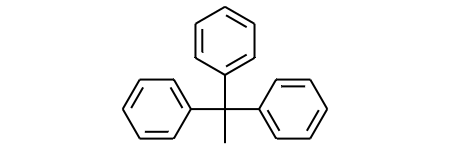

In [89]:
compound = 0
test_dataset.X[compound]
smiles = ms.iloc[test_dataset.ids[compound]]['smiles']

mol = Chem.MolFromSmiles(smiles)
mol

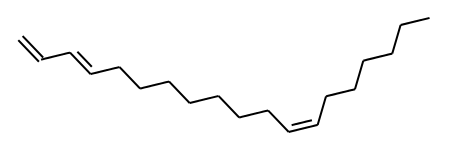

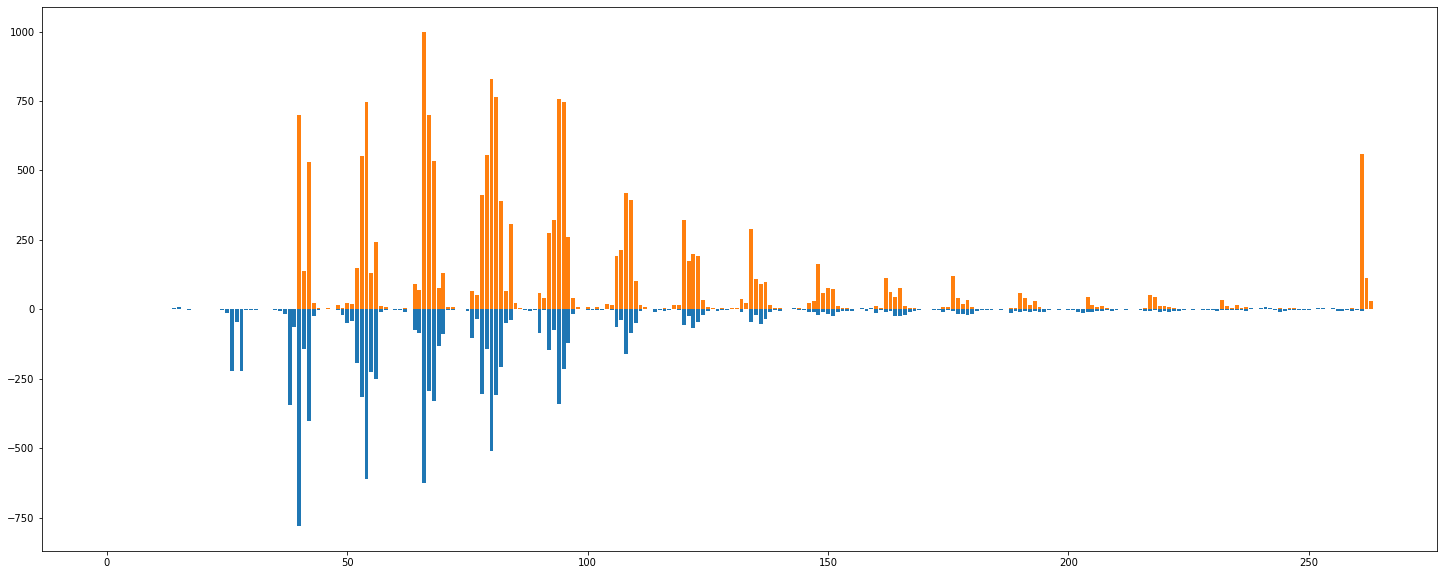

In [90]:
# Check the spectra of a test compound versus its predicted spectrum
compound = 430
smiles = ms.iloc[test_dataset.ids[compound]]['smiles']
mol = Chem.MolFromSmiles(smiles)
#mol = Chem.MolFromSmiles(X.iloc[test_dataset.ids[compound]])

max = int(Descriptors.MolWt(mol)) + 2 # scale spectrum to molecular weight of compound  
print (Chem.rdMolDescriptors.CalcExactMolWt)

plt.figure(figsize=(25,10))
n = prediction[compound][0:max].max()
plt.bar(range(max),-prediction[compound][0:max])      # inverted spectrum is the predicted spectrum
plt.bar(range(max), test_dataset.y[compound][0:max])  # real spectrum in the NIST08
#plt.bar(range(max), prediction[compound][0:max] - test_dataset.y[compound][0:max])  # real spectrum in the NIST08
mol

In [91]:
sum_all_intensities_real = test_dataset.y[compound].sum()
sum_all_intensities_pred = prediction[compound].sum()

print (f'sum all intensities real: {sum_all_intensities_real}')
print (f'sum all intensities pred: {sum_all_intensities_pred}')

sum_delta = 0
sum_real = 0
sum_pred = 0
for i in range(1000):
  delta = abs (test_dataset.y[compound][i] - prediction[compound][i])
  sum_delta = sum_delta + delta 
  sum_real = sum_real + test_dataset.y[compound][i] 
  sum_pred = sum_pred + prediction[compound][i]  
  # print (i, delta)
print (sum_delta)
print (100 - sum_delta/sum_all_intensities_pred*100)

sum all intensities real: 17232.0
sum all intensities pred: 9721.2197265625
10830.628276464793
-11.412236129905779


In [92]:
scores = []
for i in range (len(test_dataset)):
    smiles = ms.iloc[test_dataset.ids[i]]['smiles']
    mol = Chem.MolFromSmiles(smiles)
    max = int(Descriptors.MolWt(mol)) + 2
    a = test_dataset.y[i][0:max].sum()
    b = prediction[i][0:max].sum()
    c = int ((1 - abs(a-b) / a) * 100)
    print (i, c)
    scores.append(c)



0 51
1 41
2 89
3 84
4 -10
5 39
6 81
7 93
8 54
9 56
10 62
11 58
12 65
13 95
14 52
15 28
16 -12
17 80
18 99
19 57
20 74
21 66
22 72
23 96
24 38
25 95
26 44
27 51
28 87
29 75
30 66
31 76
32 39
33 82
34 81
35 48
36 35
37 22
38 95
39 16
40 96
41 32
42 98
43 92
44 85
45 69
46 86
47 60
48 96
49 64
50 19
51 80
52 79
53 88
54 66
55 60
56 85
57 85
58 76
59 87
60 42
61 73
62 58
63 74
64 10
65 83
66 58
67 50
68 45
69 33
70 26
71 98
72 53
73 50
74 69
75 96
76 0
77 81
78 72
79 33
80 80
81 46
82 67
83 99
84 75
85 83
86 90
87 23
88 65
89 44
90 85
91 90
92 69
93 88
94 52
95 0
96 54
97 29
98 23
99 61
100 12
101 96
102 30
103 73
104 97
105 94
106 52
107 97
108 62
109 29
110 62
111 73
112 38
113 79
114 50
115 90
116 93
117 60
118 86
119 59
120 70
121 48
122 -4
123 76
124 70
125 77
126 63
127 82
128 80
129 70
130 51
131 42
132 73
133 76
134 81
135 15
136 72
137 95
138 97
139 88
140 -15
141 38
142 81
143 72
144 58
145 74
146 60
147 0
148 87
149 94
150 -62
151 38
152 49
153 96
154 7
155 82
156 52
157 87
158 

In [93]:
sum(scores) / len(scores)

60.0045871559633

In [ ]:
pred_norm = prediction[compound] / prediction[compound].max()*100

In [ ]:
pred_norm.max()

999.0

In [ ]:
# Evaluation
import math
a=0
v = 100

for compound in range (len(test_dataset)):
  a = 0
  smiles = ms.iloc[test_dataset.ids[compound]]['smiles']
  mol = Chem.MolFromSmiles(smiles)
  max = int(Descriptors.MolWt(mol))
  
  for i in range (max):
    delta = abs((pred_norm[i]+v) - (test_dataset.y[compound][i]+v)) / (test_dataset.y[compound][i]+v) * 100
    #print (i, delta)
    if delta > 30:
      a=a+1 
  print (compound, 100-a)

0 99
1 99
2 99
3 99
4 99
5 99
6 99
7 99
8 99
9 99
10 99
11 99
12 99
13 99
14 99
15 99
16 99
17 99


KeyboardInterrupt: ignored

## ANY HYDROCARBON MOLECULE TO EI SPECTRUM 

In [ ]:
!pip install cirpy
import cirpy as cp

In [ ]:
# PREDICTION OF ANY HYDROCARBON 
# ENTER NAME OF A MOLECULE

smiles = 'CC(C(C=C)C)C1=CC=CC=C1'
if smiles == 'limonen':
  smiles = cp.resolve('4-Dodecen-2-yne', 'smiles') # convert name to smiles / internet connection required 

mol = rk.Chem.MolFromSmiles(smiles)
featurizer = dc.feat.CircularFingerprint(radius=3, size=2048)
features_1 = featurizer.featurize(mol)
featurizer = dc.feat.RDKitDescriptors()
features_2 = featurizer.featurize(mol)
features_3 = np.concatenate((features_2, features_1), axis=1)

ds = dc.data.NumpyDataset(X=features_3, )

prediction = model.predict(ds)
max = int(Descriptors.MolWt(mol)) + 0 # scale spectrum to molecular weight of compound  


plt.figure(figsize=(25,8))
plt.bar(range(1, max + 3),prediction[0,0:max+2])      # inverted spectrum is the predicted spectrum
plt.xlabel('MASS M/Z', fontsize=20)
plt.ylabel('PREDICTED MASS INTENSITY', fontsize=20)
# plt.bar(range(1, 100),prediction[0,0:100])      # inverted spectrum is the predicted spectrum
mol

ValueError: ignored

In [ ]:
model.save()